In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
ssn_path = '/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/sunspot.csv'
tsi_path = '/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/tsi.csv'

In [3]:
df = pd.read_csv(ssn_path)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df = df.drop(columns=['year', 'month'], axis=1)
df.head()

,ssn,date
0,135.9,1749-07-01
1,137.9,1749-08-01
2,140.2,1749-09-01
3,143.8,1749-10-01
4,146.4,1749-11-01


In [4]:
tsi = pd.read_csv(tsi_path)
tsi['date'] = pd.to_datetime(tsi[['year', 'month']].assign(DAY=1))
tsi = tsi.drop(columns=['year', 'month'], axis=1)
tsi.head()

,tsi,date
0,1363.841413,1947-08-01
1,1363.860329,1947-09-01
2,1363.898601,1947-10-01
3,1363.917975,1947-11-01
4,1363.884501,1947-12-01


Epoch 1/100


/opt/anaconda3/envs/ssn/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0370 - val_loss: 0.0030
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - val_loss: 7.9579e-04
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 5.9827e-04
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0019 - val_loss: 4.7264e-04
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0015 - val_loss: 4.2230e-04
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/

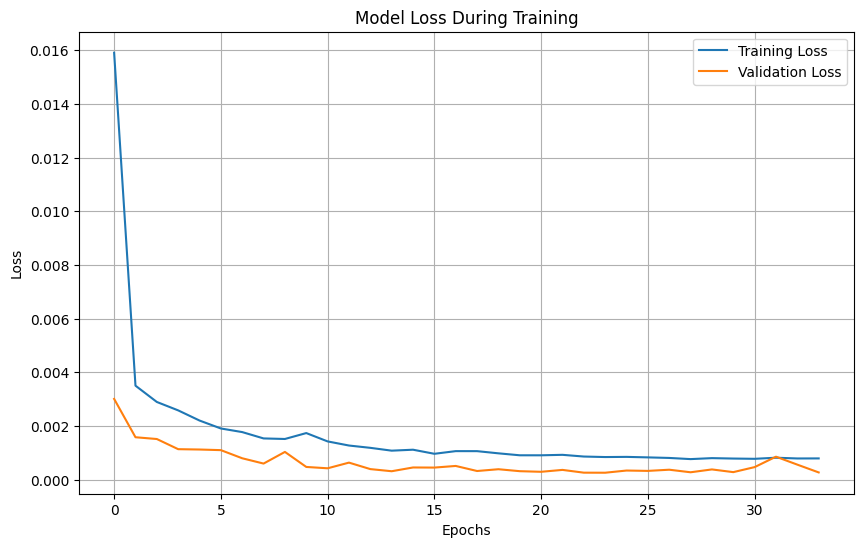

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


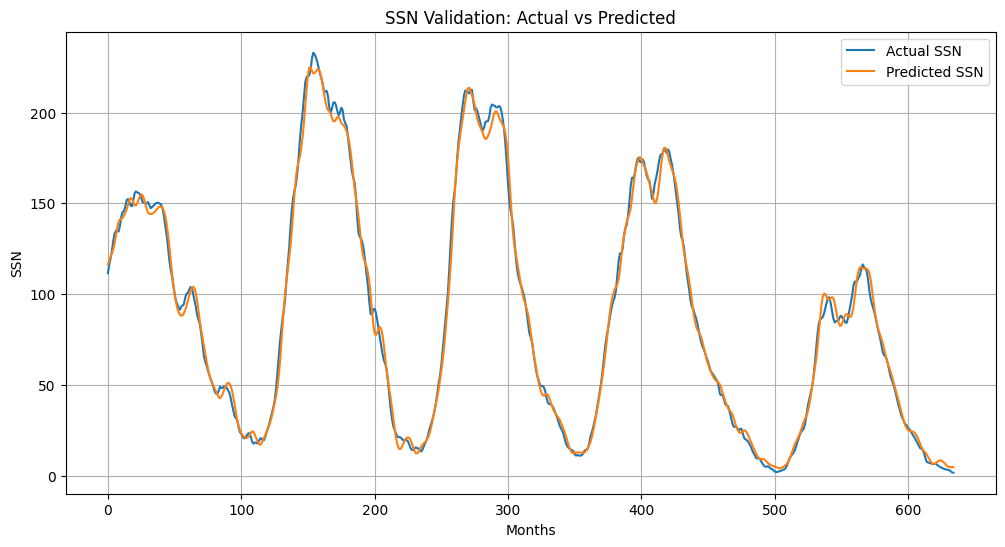

Validation RMSE: 4.5712
Validation MAE: 3.4282
Validation R²: 0.9951
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/var/folders/3b/_yf5sn_d3117s6k84tdmk97m0000gn/T/ipykernel_58269/1729296079.py:133: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1), periods=24, freq='M')


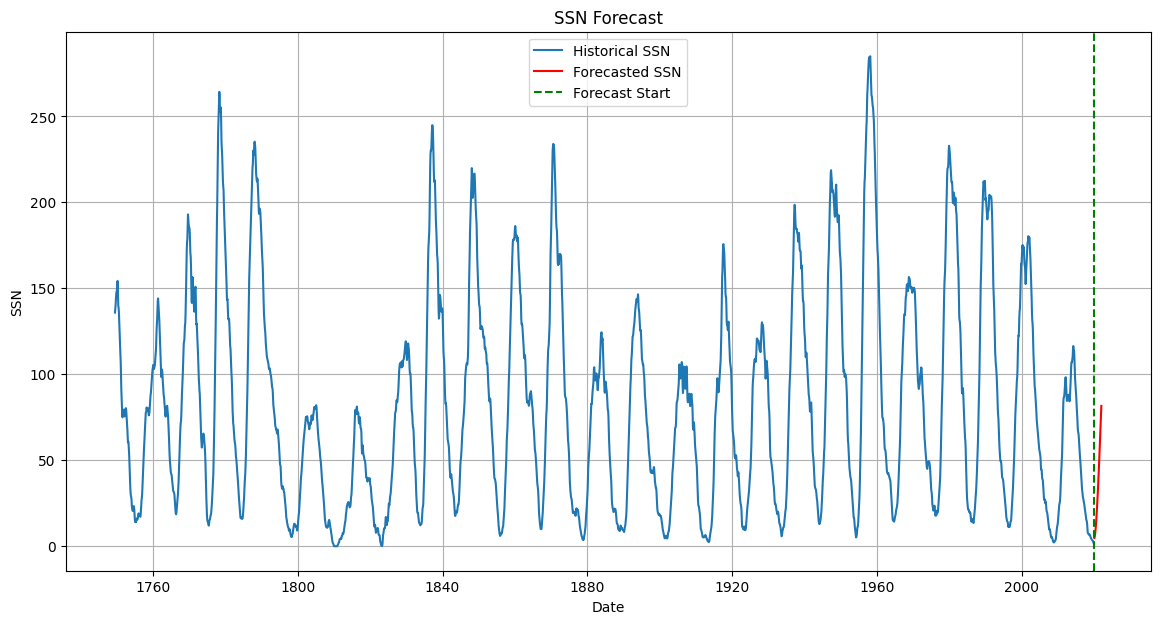

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Full Dataset Metrics:
RMSE: 4.9481
MAE: 3.6907
R²: 0.9939


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import math

# Load the data
df = pd.read_csv(ssn_path)  # Replace with your actual path
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df = df.drop(columns=['year', 'month'], axis=1)

# Filter data until 2019 (24th cycle)
train_df = df[df['date'] < '2020-01-01'].copy()

# Create sequences of 72 months (6 years) to predict 1 month ahead
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
ssn_scaled = scaler.fit_transform(train_df[['ssn']])

# Create sequences
X, y = create_sequences(ssn_scaled, 72)

# Apply weights to reduce influence of 24th cycle
# First, identify the 24th cycle approximate boundaries (2008-2019)
cycle_24_start = train_df[train_df['date'] >= '2008-01-01'].index[0]
cycle_24_indices = np.where((np.arange(len(X)) + 72) >= cycle_24_start)[0]

# Create sample weights - lower weight (0.5) for 24th cycle, normal weight (1.0) for others
sample_weights = np.ones(len(X))
sample_weights[cycle_24_indices] = 0.5

# Split into training and validation sets (80% train, 20% validation)
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
weights_train = sample_weights[:split]

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Create and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(72, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Create callbacks
checkpoint = ModelCheckpoint('ssn_forecast_model.keras', 
                             save_best_only=True, 
                             monitor='val_loss', 
                             mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with sample weights
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stop],
                    sample_weight=weights_train,
                    verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions on validation set
y_pred_scaled = model.predict(X_val)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_val)

# Plot predictions vs actual for validation set
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual SSN')
plt.plot(y_pred, label='Predicted SSN')
plt.title('SSN Validation: Actual vs Predicted')
plt.xlabel('Months')
plt.ylabel('SSN')
plt.legend()
plt.grid(True)
plt.show()

# Calculate metrics
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R²: {r2:.4f}")

# Generate future predictions (24 months ahead)
last_sequence = ssn_scaled[-72:].reshape(1, 72, 1)
future_predictions = []

for _ in range(24):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    # Update the sequence by removing the first value and adding the new prediction
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

# Convert future predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = train_df['date'].iloc[-1]
future_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1), periods=24, freq='M')

# Plot the historical data and future predictions
plt.figure(figsize=(14, 7))
plt.plot(train_df['date'], train_df['ssn'], label='Historical SSN')
plt.plot(future_dates, future_predictions, label='Forecasted SSN', color='red')
plt.axvline(x=train_df['date'].iloc[-1], color='green', linestyle='--', label='Forecast Start')
plt.title('SSN Forecast')
plt.xlabel('Date')
plt.ylabel('SSN')
plt.legend()
plt.grid(True)
plt.show()

# Calculate metrics for the full training set
full_X = X.reshape(X.shape[0], X.shape[1], 1)
full_y_pred_scaled = model.predict(full_X)
full_y_pred = scaler.inverse_transform(full_y_pred_scaled)
full_y_actual = scaler.inverse_transform(y)

full_rmse = math.sqrt(mean_squared_error(full_y_actual, full_y_pred))
full_mae = mean_absolute_error(full_y_actual, full_y_pred)
full_r2 = r2_score(full_y_actual, full_y_pred)

print("\nFull Dataset Metrics:")
print(f"RMSE: {full_rmse:.4f}")
print(f"MAE: {full_mae:.4f}")
print(f"R²: {full_r2:.4f}")

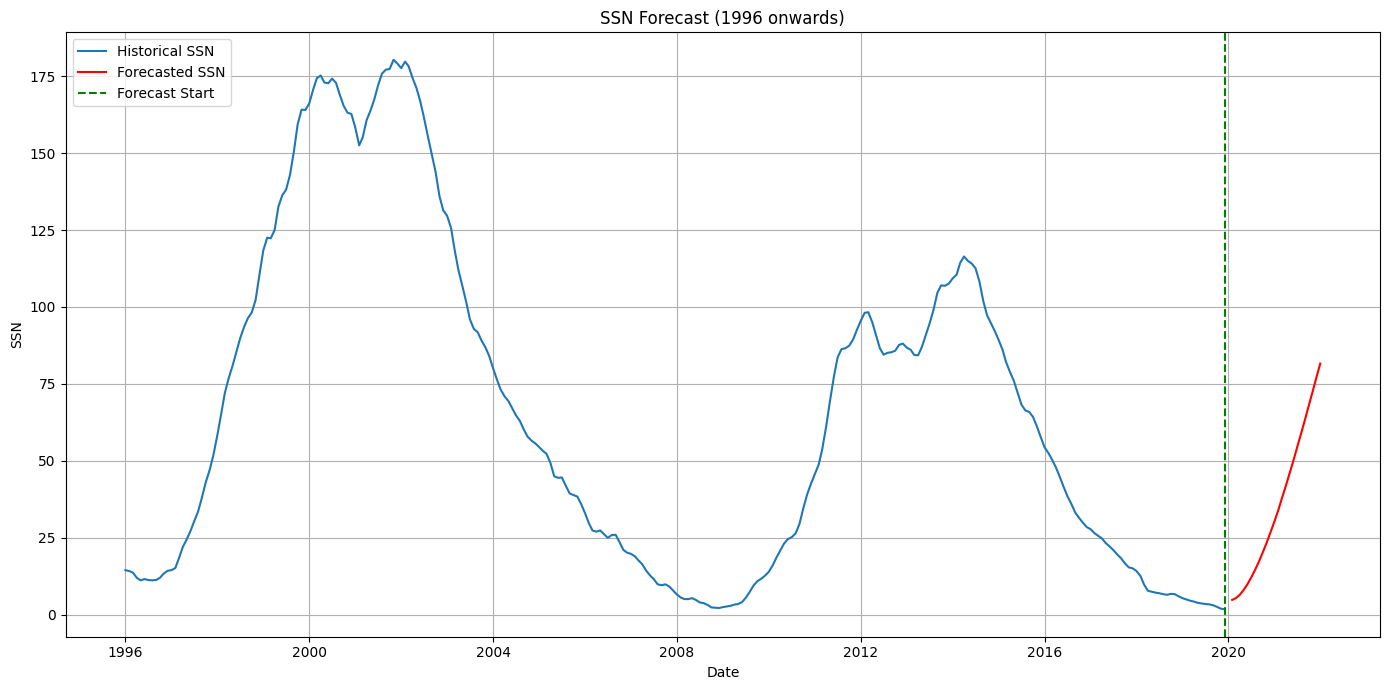

In [6]:
# Plot the historical data and future predictions - focused on recent data
plt.figure(figsize=(14, 7))

# Filter historical data from 1996 onwards
recent_df = train_df[train_df['date'] >= '1996-01-01']

# Plot historical data
plt.plot(recent_df['date'], recent_df['ssn'], label='Historical SSN')

# Plot forecast
plt.plot(future_dates, future_predictions, label='Forecasted SSN', color='red')

# Add vertical line at forecast start
plt.axvline(x=train_df['date'].iloc[-1], color='green', linestyle='--', label='Forecast Start')

# Add labels and formatting
plt.title('SSN Forecast (1996 onwards)')
plt.xlabel('Date')
plt.ylabel('SSN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

/var/folders/3b/_yf5sn_d3117s6k84tdmk97m0000gn/T/ipykernel_58269/2456855499.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1),


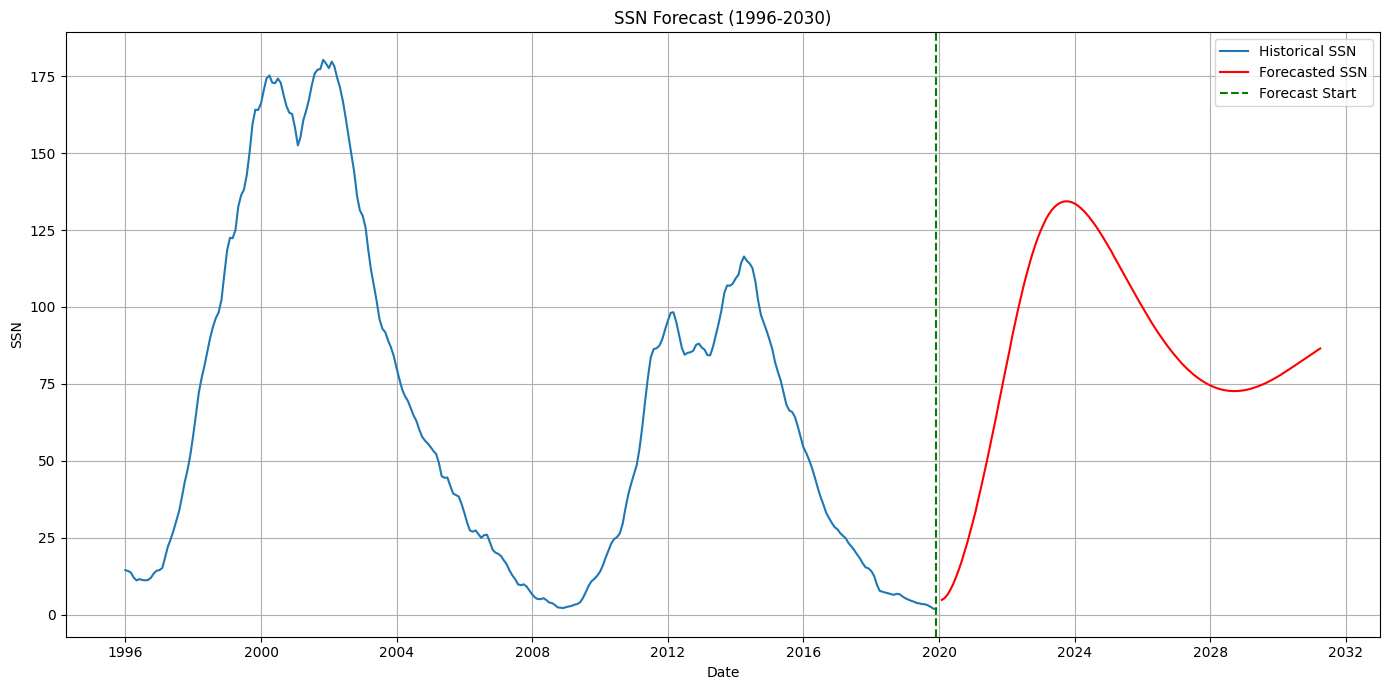

In [7]:
# Generate future predictions until 2030
last_sequence = ssn_scaled[-72:].reshape(1, 72, 1)

# Calculate how many months from the last date until end of 2030
last_date = train_df['date'].iloc[-1]
months_to_forecast = (pd.Timestamp('2030-12-31') - pd.Timestamp(last_date)).days // 30 + 1

future_predictions = []

for _ in range(months_to_forecast):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    # Update the sequence by removing the first value and adding the new prediction
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

# Convert future predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
future_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1), 
                             periods=months_to_forecast, freq='M')

# Plot the historical data and future predictions - focused on recent data
plt.figure(figsize=(14, 7))

# Filter historical data from 1996 onwards
recent_df = train_df[train_df['date'] >= '1996-01-01']

# Plot historical data
plt.plot(recent_df['date'], recent_df['ssn'], label='Historical SSN')

# Plot forecast
plt.plot(future_dates, future_predictions, label='Forecasted SSN', color='red')

# Add vertical line at forecast start
plt.axvline(x=train_df['date'].iloc[-1], color='green', linestyle='--', label='Forecast Start')

# Add labels and formatting
plt.title('SSN Forecast (1996-2030)')
plt.xlabel('Date')
plt.ylabel('SSN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()